# Risk and Strategy II

This notebook builds upon the risk analysis and trading strategies mentioned in the previous set. We cover more advanced concepts and strategies such as the Long-Short equity strategy and volatility forecasting models.

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_style(  
    "whitegrid",  
    {  
        'legend.frameon': True,  
    }  
)
matplotlib.rc('figure', figsize=(14, 8))

## Long-short equity

This strategy gets its name from the fact that it takes up both long and short positions in the equity market. It is usually used to describe a family of strategies where some model ranks all the stocks in the market. We then go long the top $n$ equities in our ranking and short the bottom $n$ while maintining an equal dollar volume between the long and short positions. Thus the strategy is market neutral and we are betting purely on the quality of our ranking scheme.

This ranking scheme can be any model that's based on factors such as technical indicators, pricing models, and etc. The returns come from the ranking spread, which we can see using the hypothetical example below.

In [2]:
# We'll generate a random factor
current_factor_values = np.random.normal(0, 1, 10000)
equity_names = ['Equity ' + str(x) for x in range(10000)]
# Put it into a dataframe
factor_data = pd.Series(current_factor_values, index = equity_names)
factor_data = pd.DataFrame(factor_data, columns=['Factor Value'])
# Take a look at the dataframe
factor_data.head(10)

,Factor Value
Equity 0,-0.205831
Equity 1,-0.237851
Equity 2,-0.510214
Equity 3,0.855933
Equity 4,0.217475
Equity 5,-0.825684
Equity 6,0.092256
Equity 7,-0.722452
Equity 8,0.507159
Equity 9,0.333123


We generate some factor values for each equity and suppose that our future returns are dependent on them.

In [3]:
# Now let's say our future returns are dependent on our factor values
future_returns = current_factor_values + np.random.normal(0, 1, 10000)

returns_data = pd.Series(future_returns, index=equity_names)
returns_data = pd.DataFrame(returns_data, columns=['Returns'])
# Put both the factor values and returns into one dataframe
data = returns_data.join(factor_data)
# Take a look
data.head(10)

,Returns,Factor Value
Equity 0,-1.240371,-0.205831
Equity 1,0.957448,-0.237851
Equity 2,0.358454,-0.510214
Equity 3,0.634109,0.855933
Equity 4,-0.110835,0.217475
Equity 5,-1.449204,-0.825684
Equity 6,-0.499394,0.092256
Equity 7,-0.228512,-0.722452
Equity 8,0.561020,0.507159
Equity 9,0.148593,0.333123


Let us now rank our equities based on the factor values, and place 500 of each into a basket. We have 10000 stocks, so this gives 20 backets in total. We take the mean of the return of all stocks in each basket, and a plot of each basket against its returns is as follows:

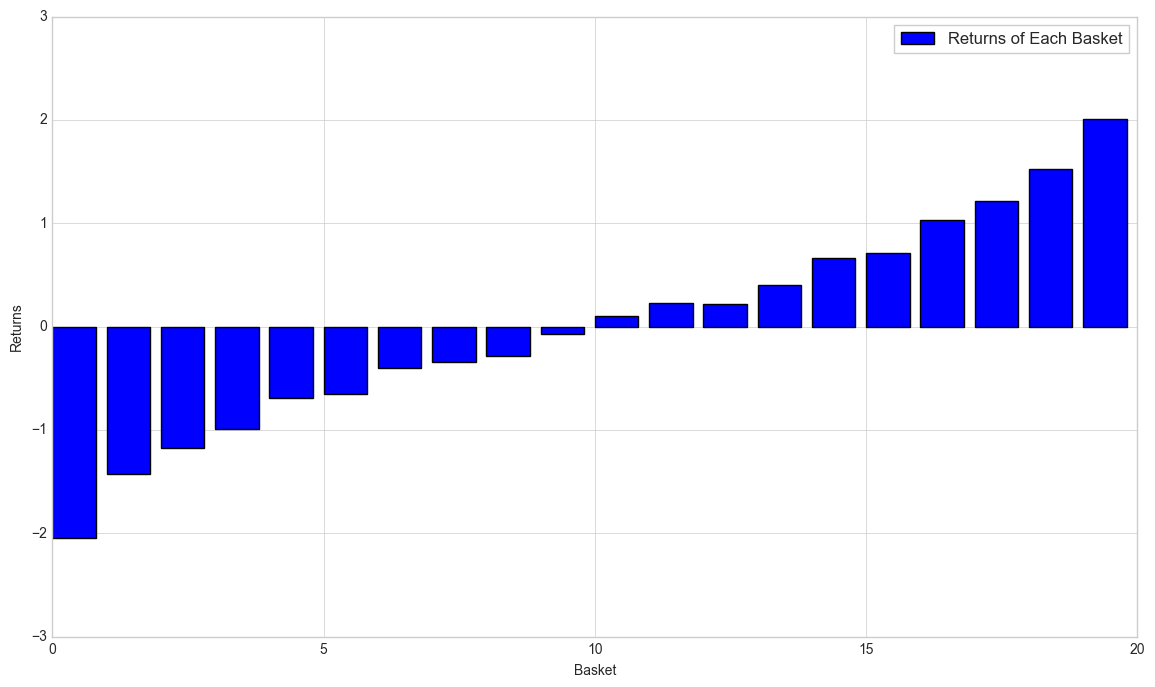

In [5]:
# Rank the equities
ranked_data = data.sort_values(by='Factor Value')

# Compute the returns of each basket
# Baskets of size 500, so we create an empty array of shape (10000/500)
number_of_baskets = 10000/500
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

# Plot the returns of each basket
plt.bar(range(number_of_baskets), basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket']);

If we go long on the top basket and short the bottom basket, this gives a return of

In [6]:
basket_returns[number_of_baskets-1] - basket_returns[0]

4.0484718054486297

### Considerations
**Rebalancing frequency.** Each ranking model has a different time-period in which it can be predictive. Trying to optimise this will lead to overfitting, giving a period that might be randomly better than others, but not necessarily because of the properties of the model used.

After determining the timeframe where the model is predictive, we should try to rebalance the portfolio at that frequency in order to take full advantage of the models.

**Capital capacity.** Every strategy has a minimum and maximum amount of capital it can trade before it stops being profitable. For example, transaction costs will add up quickly if our basket contains a large number of equities. This means the capital base will have to be high enough in order to start making profit.

## Portfolio Value at Risk (VaR)

Value at Risk is a key concept in portfolio risk management. Formally it is defined as follows:

**Definition.** Let $X$ be a random variable representing loss. Given a parameter $0<\alpha<1$, the $\alpha$-VaR of $X$ is 
$$
\text{VaR}_\alpha(X)=\min\{c:P[X\leq c]\geq\alpha\}\,.
$$

This definition can have several equivalent interpretations,
- $\text{VaR}_\alpha(X)$ is the *minimum* loss that will not exceed with probability $\alpha$
- $\text{VaR}_\alpha(X)$ is the $\alpha$-quantile of the distribution of $X$
- $\text{VaR}_\alpha(X)$ is the *smallest* loss in the $(1-\alpha)\times100\%$ worst cases
- $\text{VaR}_\alpha(X)$ is the *highest* loss in the $\alpha\times100\%$ best cases.

In practice, we use past observed distribution of portfolio returns to estimate what your future losses might be at difference likelihood levels. Let's demonstrate this concept through an example.

In [12]:
# imports
from scipy.stats import norm
import time

We simulate returns of 10 hypothetical assets using normal distributions. Note that in practice the distribution of returns do not have this property and usually exhibit strange behaviour such as fat-tailedness.

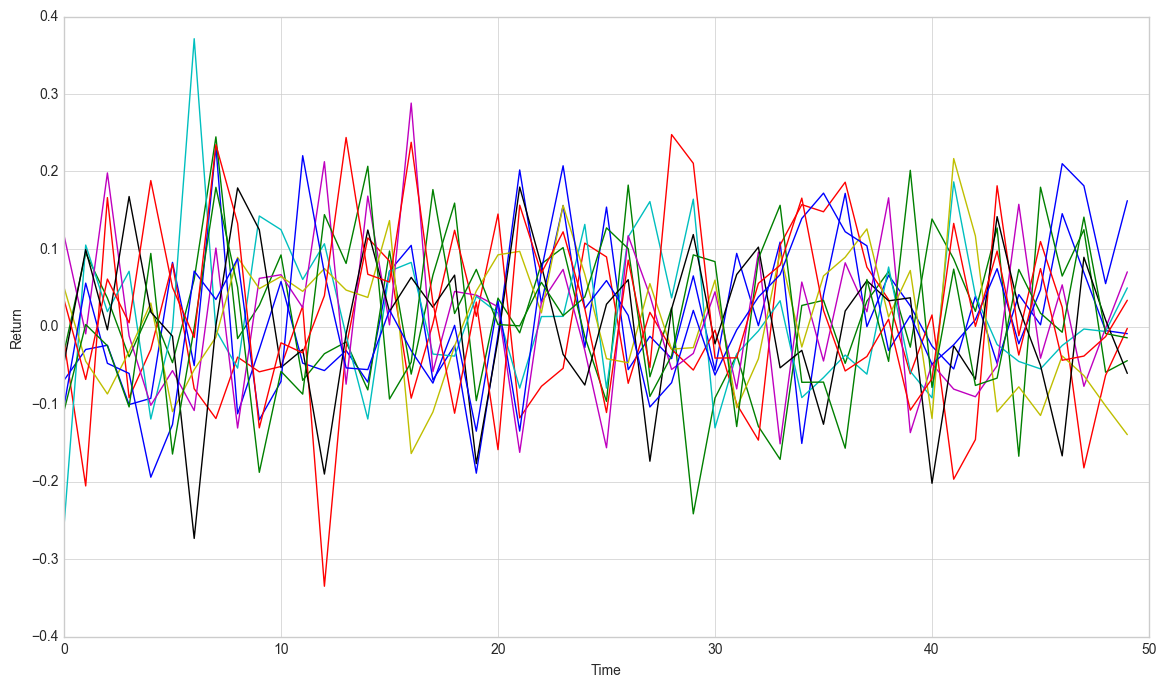

In [7]:
# mu = 0.01, std = 0.10, 1000 bars, 10 assets
mu = 0.01
sigma = 0.10
bars = 1000
num_assets = 10

returns = np.random.normal(mu, sigma, (bars, num_assets))

# Fake asset names
names = ['Asset %s' %i  for i in range(num_assets)]

# Put in a pandas dataframe
returns = pd.DataFrame(returns, columns=names)

# Plot the last 50 bars
plt.plot(returns.head(50))
plt.xlabel('Time')
plt.ylabel('Return');

The Value at Risk for coverage $\alpha$ is defined as the maximum amount we expect to lose with probability $p=1-\alpha$. In other words, we do not expect to lose more than the VaR within $100p\%$ days. With this definition, it is obvious that there is some relation between VaR and confidence intervals. Since it is generally difficult to estimate confidence intervals accurately, the same can be said for the VaR.

The VaR for a high $\alpha$ can be used as a measure of worst case outcomes. For example a $\alpha=0.999$ VaR gives how a 1/1000 crisis event might affect a portfolio. Real distributions tend to diverge and be less consistent the further along the tail however, and so extreme VaR should be taken with a grain of salt.

### Historical (Non-parametric) VaR

Historical VaR looks at previous returns distributions and uses that to compute the $p$ percentile. This percentile is the amount of loss we can expect to experience with probability $p$, assuming future returns are close to past returns. One potential drawback with this method is that if our historical window does not include any crisis events, then our VaR estimates will be far lower than it should be.

Note that by *non-parametric* we mean that we are not assuming any distribution for future returns.

To compute the historical VaR for coverage $\alpha$, we take the $100(1-\alpha)$ percentile of lowest observed returns and multiply that by the total value invested. Let us do that with our current set of assets. We will need a set of portfolio weights.

In [8]:
weights = np.ones((10, 1))
# Normalize
weights = weights / np.sum(weights)

In [9]:
def value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    returns = returns.fillna(0.0)
    # Multiply asset returns by weights to get one weighted portfolio return
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    # Compute the correct percentile loss and multiply by value invested
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

In [10]:
value_invested = 1000000

value_at_risk(value_invested, returns, weights, alpha=0.95)

-45205.038329804695

So for $\alpha=0.95$, we see that historically no more than $5\%$ of days resulted in losses more extreme than $\sim 45000$, or that on each day the probability of losing this much is less than $5\%$.

Essentially what we are doing here is drawing from a histogram, and finding the point where only $100(1-\alpha)\%$ of the points are below that return. That point is the VaR of return for coverage $\alpha$.

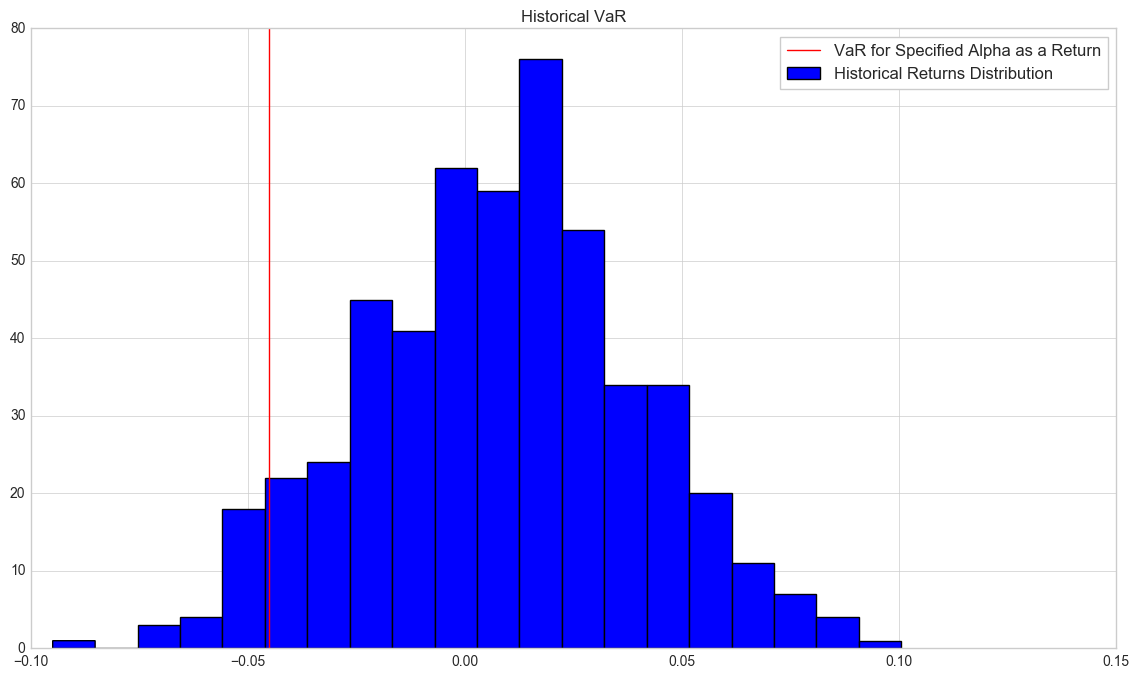

In [15]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns, bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');

### Normal VaR

Since our returns were simulted from a normal distribution, we can use the normal VaR, where we assume that the returns follow the (normal) distribution. Using the inverse normal CDF, this gives a value associated with a particular likelihood. Specifically, the closed form equation for the normal VaR is
$$
\text{VaR}_\alpha(x) = \mu-\sigma\Phi^{-1}(\alpha)\,.
$$

In [13]:
# Portfolio mean return is unchanged, but std has to be recomputed
# This is because independent variances sum, but std is sqrt of variance
portfolio_std = np.sqrt( np.power(sigma, 2) * num_assets ) / num_assets

# manually 
(mu - portfolio_std * norm.ppf(0.95)) * value_invested

-42014.838787555738

This seems close enough to within some random variance. Let us now visualise the continuous normal case. Notice that the VaR is expressed as a return rather than an absolute loss. To get absolute loss we multiply by value invested.

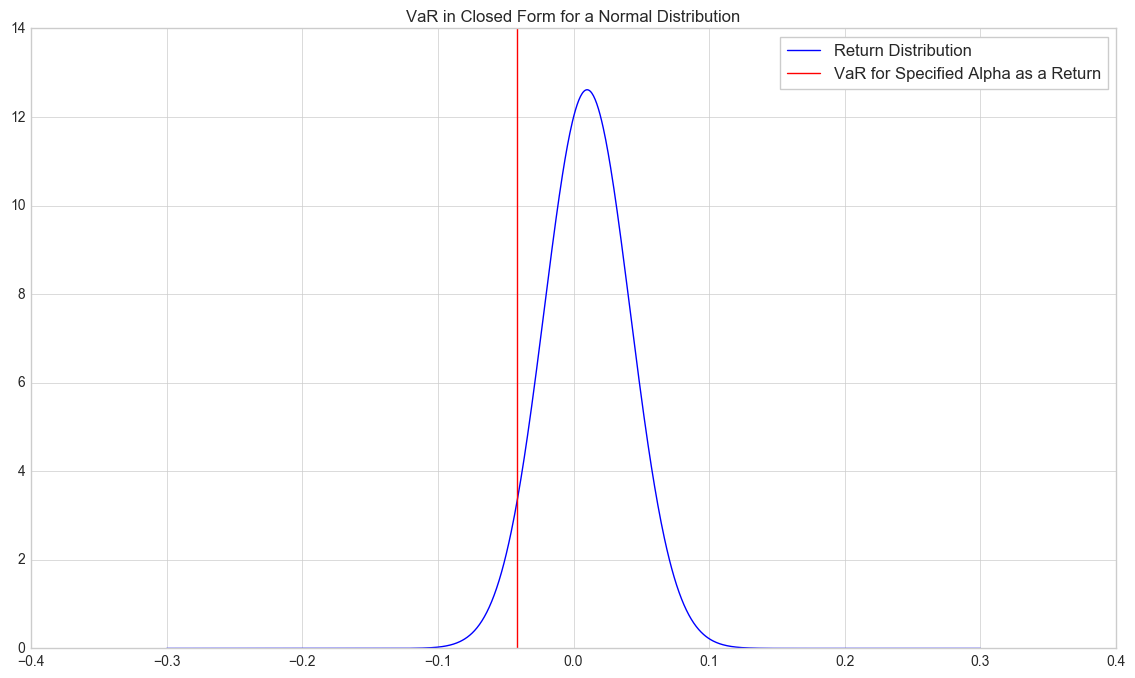

In [14]:
def value_at_risk_N(mu=0, sigma=1.0, alpha=0.95):
    return mu - sigma*norm.ppf(alpha)


x = np.linspace(-3*sigma,3*sigma,1000)
y = norm.pdf(x, loc=mu, scale=portfolio_std)
plt.plot(x,y);
plt.axvline(value_at_risk_N(mu = 0.01, sigma = portfolio_std, alpha=0.95), color='red', linestyle='solid');
plt.legend(['Return Distribution', 'VaR for Specified Alpha as a Return'])
plt.title('VaR in Closed Form for a Normal Distribution');

### Real data example

Let us use our techniques on some real financial data.

In [18]:
# Use stocks from HSI constituents
tickers = ["0001.HK","0002.HK","0003.HK","0006.HK","0016.HK","0019.HK","0023.HK","0027.HK","0083.HK","0101.HK","0135.HK","0144.HK","0175.HK","0267.HK","0288.HK","0293.HK","0386.HK","0388.HK","0688.HK","0823.HK","0836.HK","0857.HK","0883.HK","0939.HK","0941.HK","0992.HK","1038.HK","1044.HK","1109.HK","1113.HK","1299.HK","1398.HK","1928.HK","2018.HK","2318.HK","2319.HK","2388.HK","2628.HK","3328.HK"]

num_stocks = len(hsi)

In [17]:
from finance import utils

In [20]:
start = time.time()
data = utils.get_pricing(tickers,"yhoo", "2014-01-01","2016-04-04", "close")
end = time.time()
print "Time: %0.2f seconds." % (end - start)

Time: 24.21 seconds.


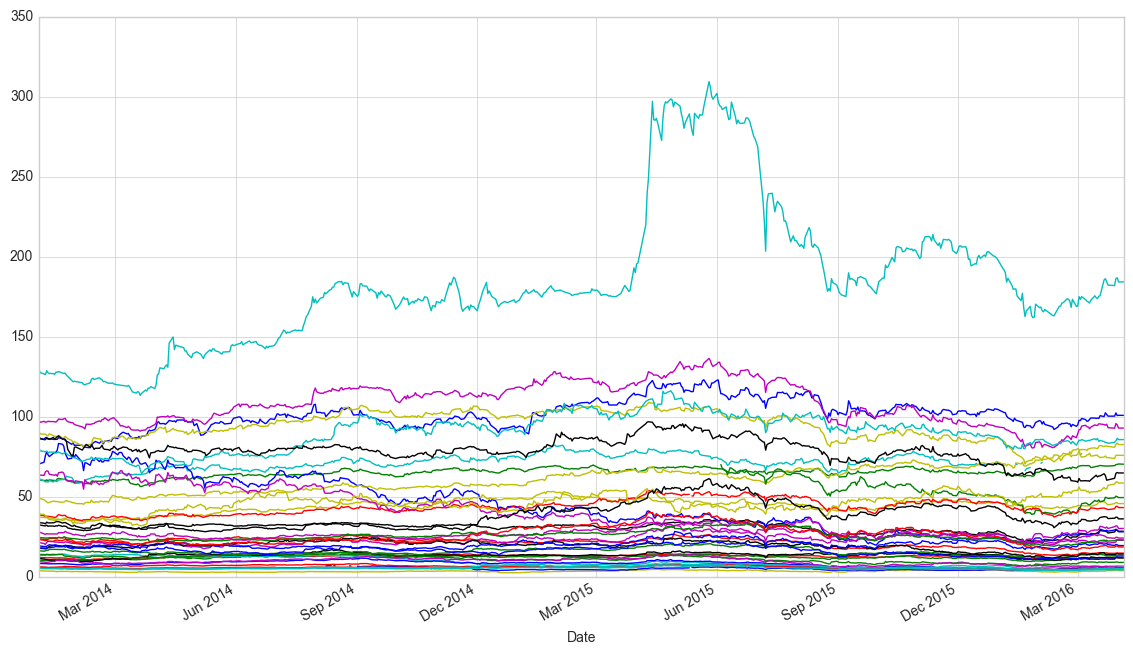

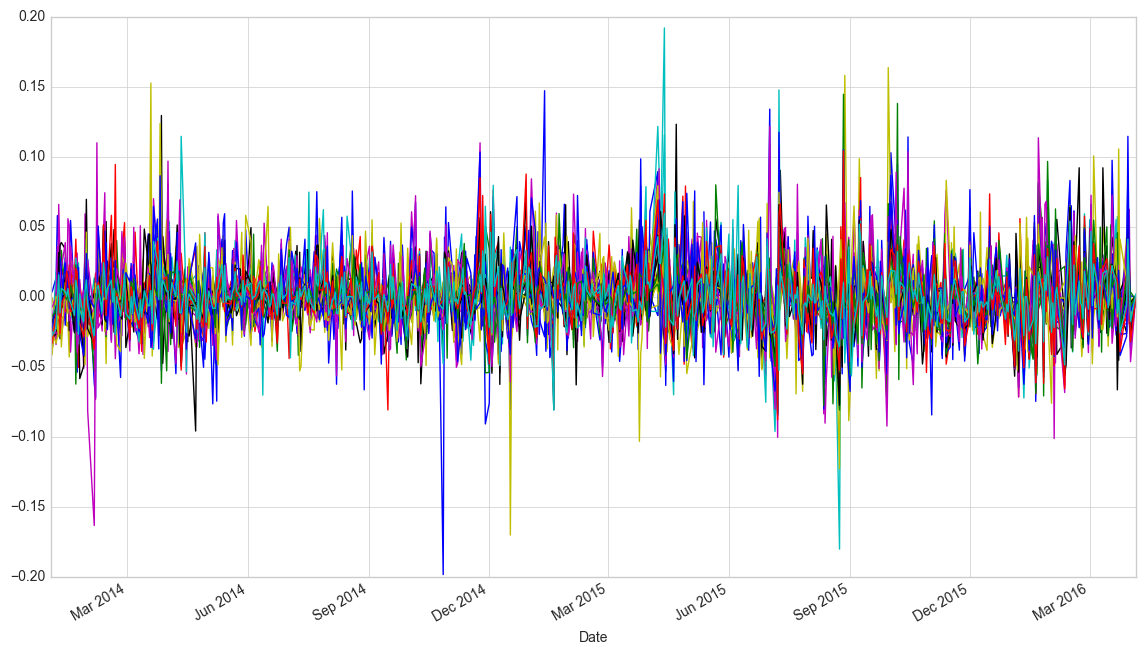

In [21]:
returns = data.pct_change()
returns = returns - returns.mean(skipna=True) # de-mean the returns

data.plot(legend=None);
returns.plot(legend=None);

Now we generate some weights as our portfolio and calculate the VaR for $\alpha=0.95$. We write this as $\text{VaR}_{\alpha=0.95}$.

-18635.642764654447

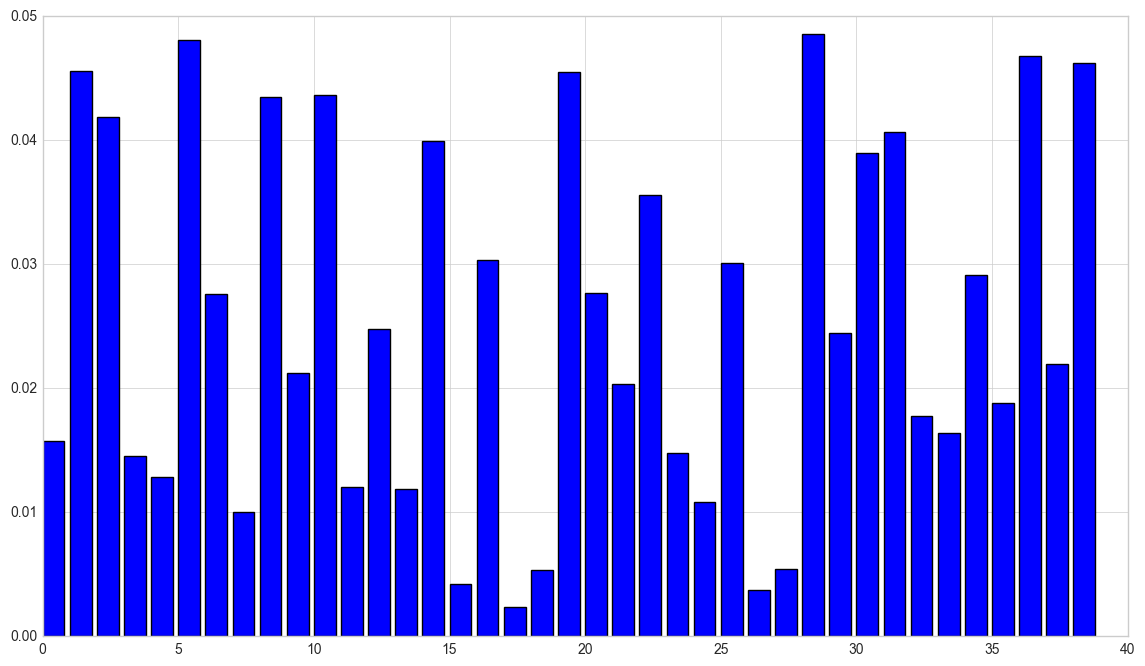

In [22]:
def scale(x):
    return x / np.sum(np.abs(x))

weights = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks),weights);

value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520)

Let's visualise this.

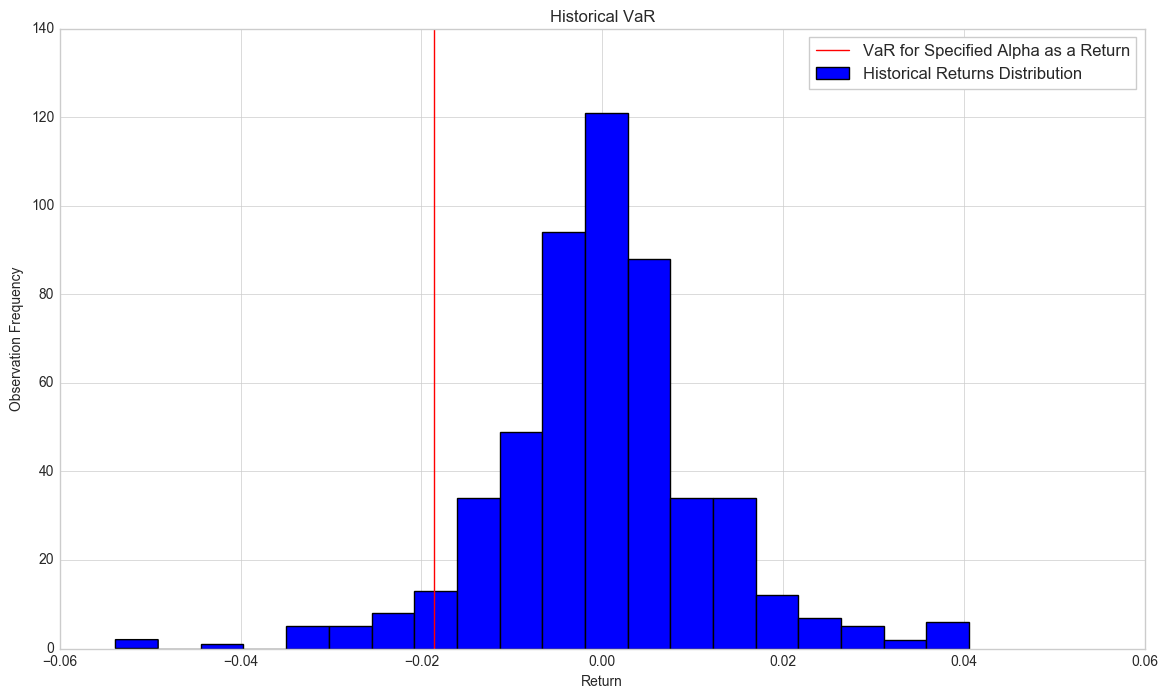

In [23]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns, bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

The distribution looks visibly non-normal, but let's verify it properly using the Jarque-Bera test and a p-value cutoff of 0.05.

In [24]:
from statsmodels.stats.stattools import jarque_bera

_, pvalue, _, _ = jarque_bera(portfolio_returns)

if pvalue > 0.05:
    print 'The portfolio returns are likely normal.'
else:
    print 'The portfolio returns are likely not normal.'

The portfolio returns are likely not normal.


Indeed they are not normal, and thus we should not assume a normal distribution in calculating the VaR.

### The lookback window

Note that our "non-parametric" historical VaR is not entirely devoid of parameters. The lookback window affects our value for the VaR, and it is important to pick a lookback window that's long enough for the VaR to converge. To check if our value has converged when can run an experiment.

Additionally, while a 500 day window may yield convergence, it might be ignoring a financial collapse that happened 1000 days ago, which is crucial data. Using all the time data does not help as well, since the returns variance may be non-stationary. Thus we should really just be picking a "sensible" window.

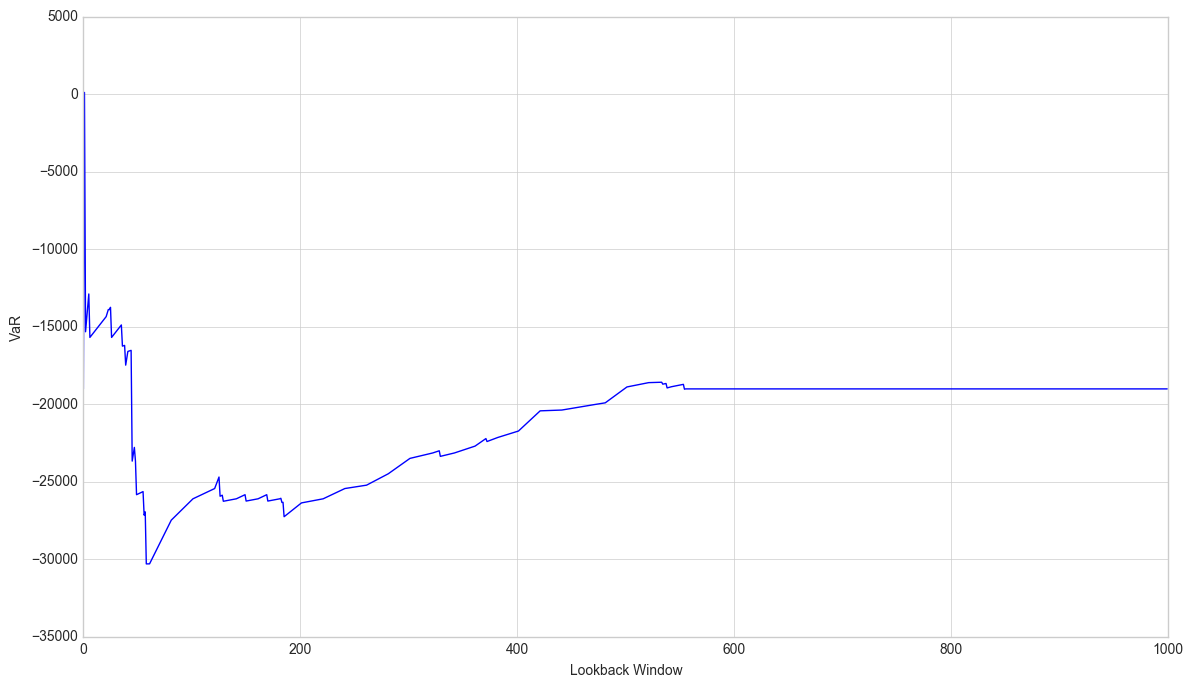

In [25]:
N = 1000
VaRs = np.zeros((N, 1))
for i in range(N):
    VaRs[i] = value_at_risk(value_invested, returns, weights, lookback_days=i)

plt.plot(VaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

We see here that the VaR does appear to converge within a 400-600 lookback window period, so our choice of a 520 day lookback should be fine. In fact, 1000 days may be a better choice solely because it uses more information, but more computationally intensive and prey to stationarity concerns.

This sort of analysis is useful in looking at whether a VaR is meaningful. Another check we can do is to check for stationarity in portfolio returns over this time period.

In [26]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(portfolio_returns)
pvalue = results[1]

if pvalue < 0.05:
    print 'Process is likely stationary.'
else:
    print 'Process is likely non-stationary.'

Process is likely stationary.


## Conditional Value at Risk (CVaR)

The conditional value at risk can be considered as an improvement on the VaR, as it takes into account the shape of the returns distribution. It is also known as the expected shortfall (ES), as it is an expectation over all the different possible losses greater than VaR and their corresponding estimated likelihoods.

**Definition.** Let $X$ be a continuous random variable representing loss. Given a paramter $0<\alpha<1$, the $\alpha$-CVaR of $X$ is 
$$
\text{CVaR}_\alpha(X)=\mathbb{E}[X\,|\,X\geq\text{VaR}_\alpha(X)]\,.
$$

The expression for CVaR above can be written in terms of an integral,
$$
\text{CVaR}_\alpha(X)=\frac{1}{1-\alpha}\int_\alpha^1\text{VaR}_\beta(X)d\beta\,.
$$

In [27]:
def cvar(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    # Call out to our existing function
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    # Get back to a return rather than an absolute loss
    var_pct_loss = var / value_invested
    
    return value_invested * np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss])

Let us compare the two on our data.

In [29]:
print "CVaR: " + str(cvar(value_invested, returns, weights, lookback_days=500))
print "VaR: " + str(value_at_risk(value_invested, returns, weights, lookback_days=500))

CVaR: -28526.5784554
VaR: -18951.3123269


The CVaR is higher as it is capturing more information about the shape of the distribution, i.e. the moments of the distribution. If the tails have more mass, it accounts for that. Thus it is in general considered to be a far superior metric than the VaR.

Let's visualise what it's capturing.

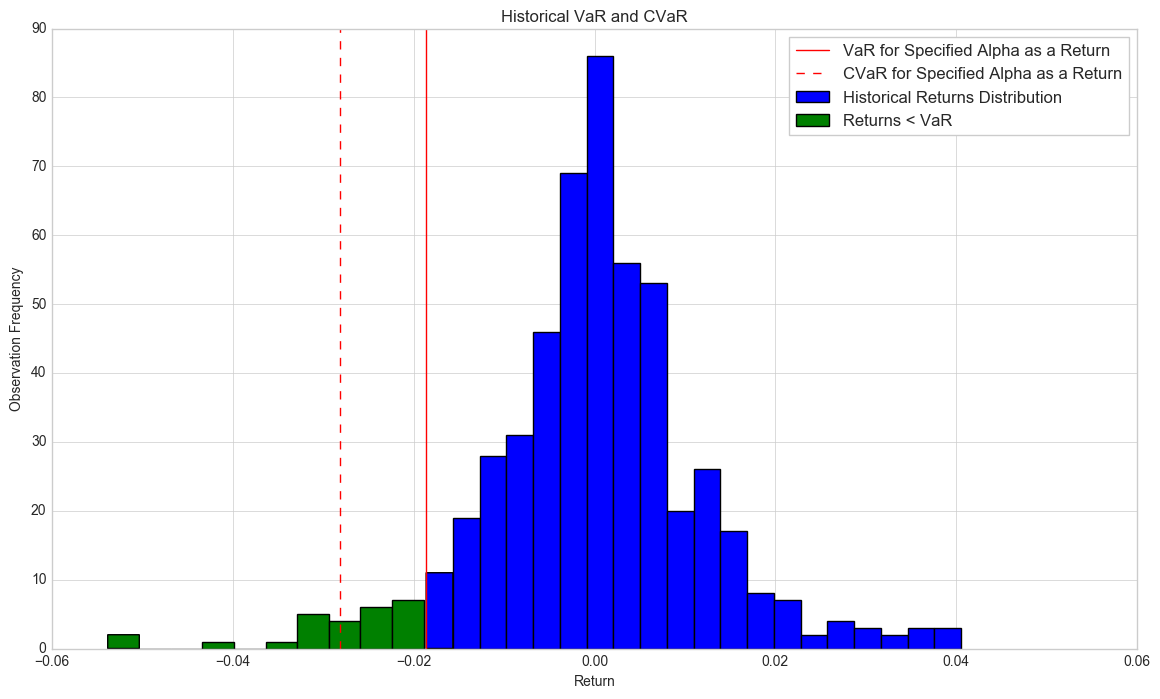

In [30]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_CVaR_return = portfolio_CVaR / value_invested

# Plot only the observations > VaR on the main histogram so the plot comes out
# nicely and doesn't overlap.
plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed');
plt.legend(['VaR for Specified Alpha as a Return',
            'CVaR for Specified Alpha as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Historical VaR and CVaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

We can, again check for convergence.

C:\Python27\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: Mean of empty slice


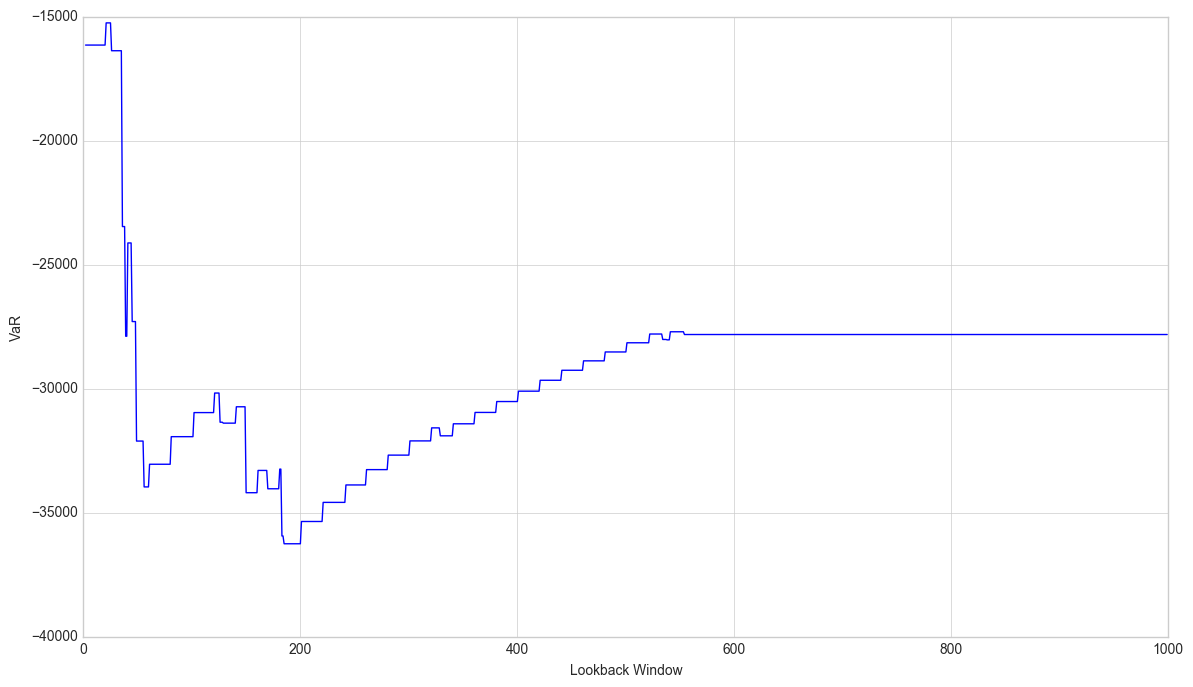

In [31]:
N = 1000
CVaRs = np.zeros((N, 1))
for i in range(N):
    CVaRs[i] = cvar(value_invested, returns, weights, lookback_days=i)

plt.plot(CVaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

## ARCH and GARCH Models

The autoregressive conditional heteroskedasticity (ARCH) model is used for describing a time series where its variance follows an autoregressive model. Suppose $\epsilon_t$ are error terms (return residuals wrt a mean process) which can be split into a stochastic piece $z_t$ and a time-dependent standard deviation $\sigma_t$ characterising the typical size of the terms s.t.
$$
\epsilon_t = \sigma_tz_t\,.
$$
Here $z_t$ is a white noise process, and the series $\sigma_t^2$ is modelled by
$$
\sigma_t^2 = \alpha_0+\alpha_1\epsilon_{t-1}^2+\dots+\alpha_q\epsilon_{t-q}^2 = \alpha_0+\sum_{i=1}^q\alpha_i\epsilon_{t-i}^2\,,
$$
where $\alpha_0>0$ and $\alpha_i\geq0$, $i>0$.

The generalised autoregressive conditional heteroskedasticity (GARCH) model is where the variance has an autoregressive moving average (ARMA) model. A GARCH(p,q) has the following dynamics:
$$
\begin{align}
y_t&=x_t'b+\epsilon_t\\
\epsilon_t&\sim \mathcal{N}(0,\sigma_t^2)\\
\sigma_t^2 &= \omega+\sum_{i=1}^q\alpha_i\epsilon_{t-i}^2 + \sum_{i=1}^p \beta_i\sigma_{t-i}^2\,.
\end{align}
$$

A GARCH(1,1) process has the following dynamics:
$$
\begin{align}
\sigma_1&=\sqrt{\frac{a_0}{1-a_1-b_1}}\\
\sigma_t^2&=a_0+a_1x_{t-1}^2+b_1\sigma_{t-1}^2\\
x_t&=\sigma_t\epsilon_t\\
\epsilon&\sim\mathcal{N}(0,1)\,.
\end{align}
$$
We will simulate this using Monte Carlo sampling with parameters $a_0=1$, $a_1=0.1$, $b_1=0.8$. We drop the first 10% (burn-in) of our simulated values.

In [43]:
import cvxopt
from functools import partial
import math
import scipy
from scipy import stats

In [33]:
# Define parameters
a0 = 1.0
a1 = 0.1
b1 = 0.8
sigma1 = math.sqrt(a0 / (1 - a1 - b1))

In [34]:
def simulate_GARCH(T, a0, a1, b1, sigma1):
    
    # Initialize our values
    X = np.ndarray(T)
    sigma = np.ndarray(T)
    sigma[0] = sigma1
    
    for t in range(1, T):
        # Draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # Draw the next sigma_t
        sigma[t] = math.sqrt(a0 + b1 * sigma[t - 1]**2 + a1 * X[t - 1]**2)
        
    X[T - 1] = sigma[T - 1] * np.random.normal(0, 1)    
    
    return X, sigma

Let us compare the tails of the GARCH(1,1) process with normally distributed values. We should see fatter tails, since the GARCH(1,1) process will experience extreme values more often.

In [35]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in
X = X / np.std(X) # Normalize X

def compare_tails_to_normal(X):
    # Define matrix to store comparisons
    A = np.zeros((2,4))
    for k in range(4):
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # Estimate tails of X
        A[1, k] = 1 - stats.norm.cdf(k + 1) # Compare to Gaussian distribution
    return A

compare_tails_to_normal(X)

array([[  1.53111111e-01,   2.55555556e-02,   2.00000000e-03,
          1.11111111e-04],
       [  1.58655254e-01,   2.27501319e-02,   1.34989803e-03,
          3.16712418e-05]])

Graphically this is harder to see:

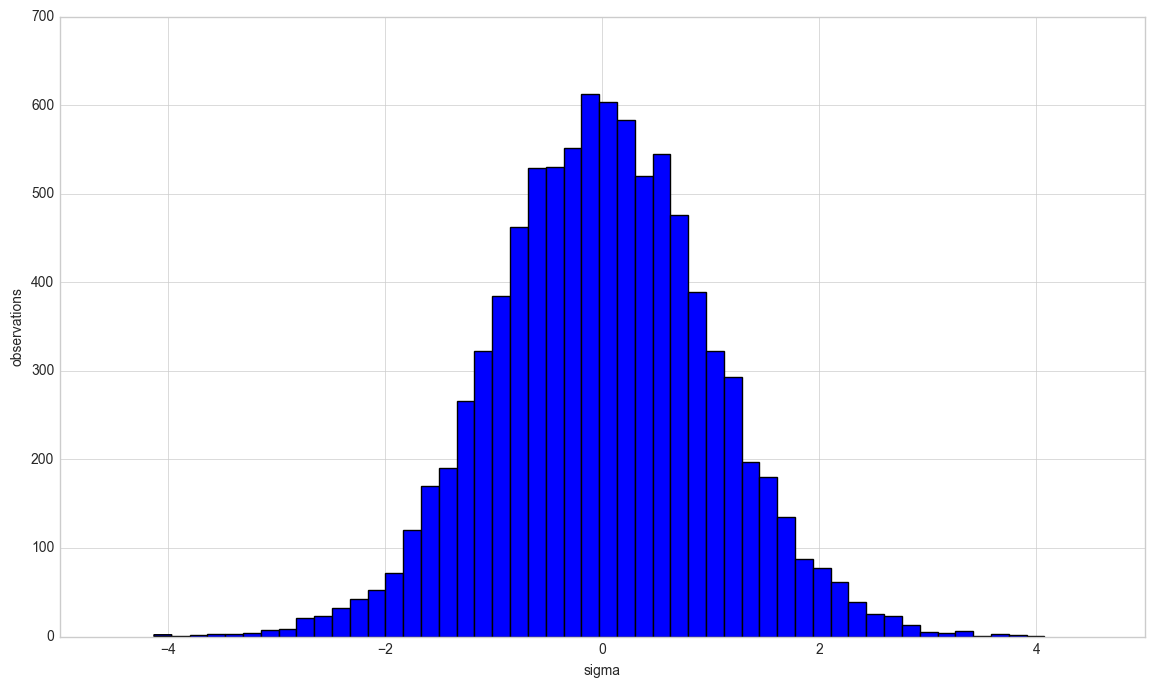

In [38]:
plt.hist(X, bins=50)
plt.xlabel('sigma')
plt.ylabel('observations');

In [39]:
# Sample values from a normal distribution
X2 = np.random.normal(0, 1, 9000)
both = np.matrix([X, X2])

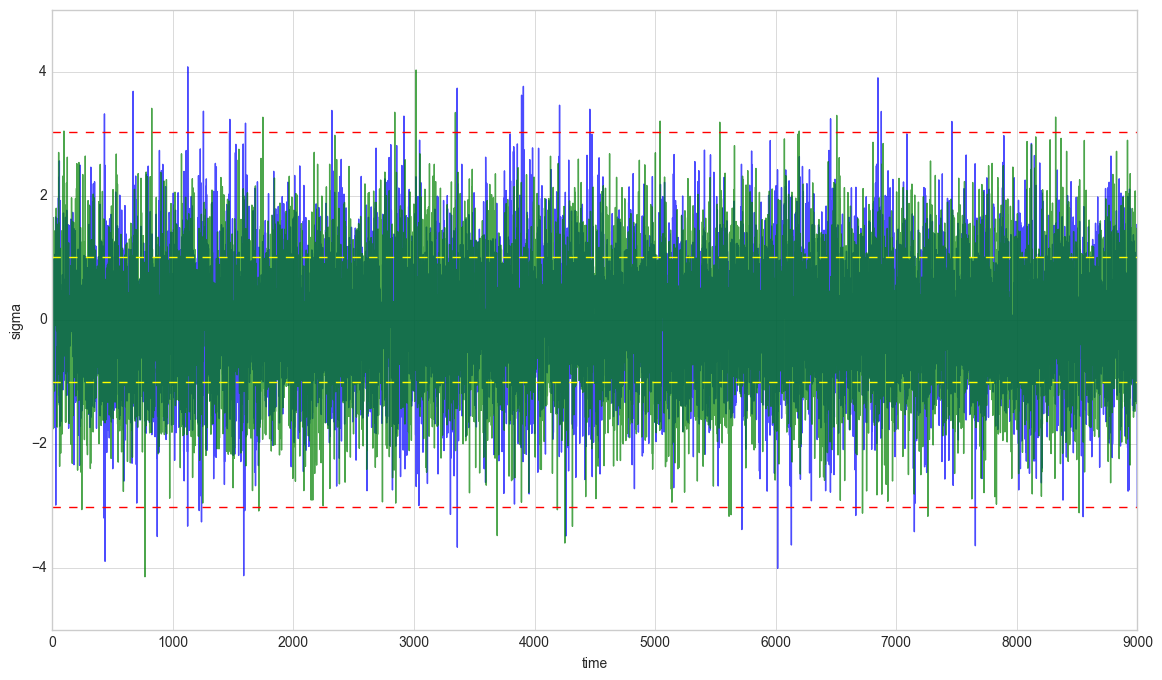

In [40]:
# Plot both the GARCH and normal values
plt.plot(both.T, alpha=.7);
plt.axhline(X2.std(), color='yellow', linestyle='--')
plt.axhline(-X2.std(), color='yellow', linestyle='--')
plt.axhline(3*X2.std(), color='red', linestyle='--')
plt.axhline(-3*X2.std(), color='red', linestyle='--')
plt.xlabel('time')
plt.ylabel('sigma');

Here the GARCH process is in blue and the normal process in green. We have plotted the 1 and 3 std bars. Observe that the blue GARCH process crosses the 3 std bar much more often than the green normal one.

### Testing for ARCH behaviour

To test for ARCH conditions, we run a regression on $x_t$ fitting the following model:
$$
x_t^2=a_0+a_1x_{t-1}^2+\dots+a_px_{t-p}^2\,.
$$
We then use OLS to estimate $\hat{\theta}=(\hat{a}_0,\hat{a}_1,\dots,\hat{a}_p)$ and the covariance matrix $\hat{\Omega}$. The test statistic
$$
F=\hat{\theta}\hat{\Omega}^{-1}\hat{\theta}^T
$$
can then be used to compare with the $\chi^2(p)$ distibution. If $F$ is greater than the 95% bars then we reject the null hypothesis. Here we choose $p=20$.

(20L, 1L)
F = 366.331040239
p-value = 0.0
[[ 67.14285297  53.14289041  81.59557993  49.96894063  33.56263989
   26.80663037  23.06714112  -7.37474084  21.9827001   13.54113592
   38.62665583  46.55727665   8.73733845  10.36786383  -1.63566924
   27.04831582  25.17920489  42.98832285  16.23638296  44.06642356]]


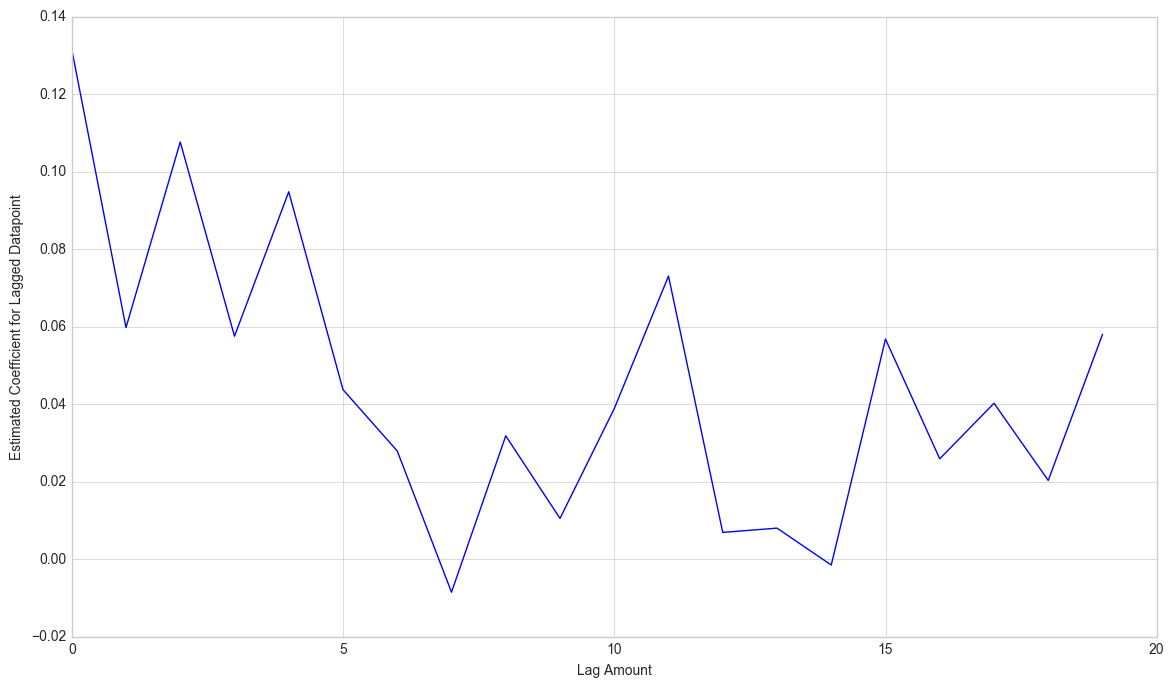

In [44]:
X, _ = simulate_GARCH(1100, a0, a1, b1, sigma1)
X = X[100:] # Drop burn in

p = 20

# Drop the first 20 so we have a lag of p's
Y2 = (X**2)[p:]
X2 = np.ndarray((980, p))
for i in range(p, 1000):
    X2[i - p, :] = np.asarray((X**2)[i-p:i])[::-1]

model = sm.OLS(Y2, X2)
model = model.fit()
theta = np.matrix(model.params)
omega = np.matrix(model.cov_HC0)
F = np.asscalar(theta * np.linalg.inv(omega) * theta.T)

print np.asarray(theta.T).shape

plt.plot(range(20), np.asarray(theta.T))
plt.xlabel('Lag Amount')
plt.ylabel('Estimated Coefficient for Lagged Datapoint')

print 'F = ' + str(F)

chi2dist = scipy.stats.chi2(p)
pvalue = 1-chi2dist.cdf(F)
print 'p-value = ' + str(pvalue)

# Finally let's look at the significance of each a_p as measured by the standard deviations away from 0
print theta/np.diag(omega)

### Fitting with MLE

Once we have evidence that our data might have an underlying GARCH(1,1) model, we can try to fit it through estimating the parameters. To do this we use the log-likelihood function
$$
\mathcal{L}(\theta)=\sum_{t=1}^T\left(-\ln\sqrt{2\pi}-\frac{x_t^2}{2\sigma_t^2}-\frac{1}{2}\ln(\sigma_t^2)\right)\,.
$$
Evaluating this requires $x_t$ and $\sigma_t$ for $1\leq t\leq T$. We have $x_t$ but we need to compute $\sigma_t$. To do this we make a guess for $\sigma_1$:
$$
\sigma_1^2=\hat{\mathbb{E}}[x_t^2]\,.
$$
Then the rest of the terms are computed using
$$
\sigma_t^2=a_0+a_1x_{t-1}^2+b_1\sigma_{t-1}^2\,.
$$

In [45]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # Drop burn in

In [46]:
# Here's our function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

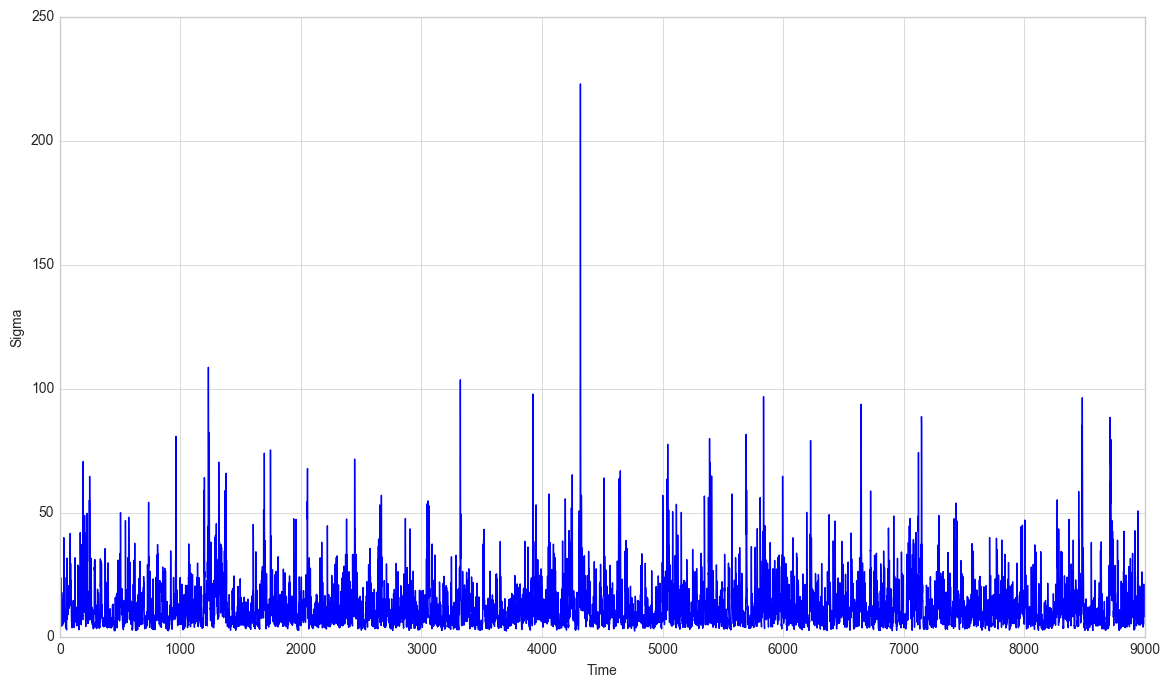

In [47]:
plt.plot(range(len(X)), compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), (1, 0.5, 0.5)))
plt.xlabel('Time')
plt.ylabel('Sigma');

This gives the sigmas that we just generated. We now need to define our log-likelihood function and we do it such that it returns $-\mathcal{L}(\theta)$. This way when we use it in our numerical optimiser we can maximise the log-likelihood by minimising our function.

In [48]:
def negative_log_likelihood(X, theta):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

We now perform numerical optimisation using
$$
\hat{\theta}=\arg\max_{(a_0,a_1,b_1)}\mathcal{L}(\theta)=\arg\min_{(a_0,a_1,b_1)}-\mathcal{L}(\theta)
$$
with the constraints
$$
a_1\geq0\,,\quad b_1\geq0\,,\quad a_1+b_1 <1\,.
$$

In [49]:
# Make our objective function by plugging X into our log likelihood function
objective = partial(negative_log_likelihood, X)

# Define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})

# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
theta_mle = result.x
print 'theta MLE: ' + str(theta_mle)

C:\Python27\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in log


theta MLE: [ 1.11900206  0.10112335  0.78957727]


We check our estimates by looking at the following:
1. How fat the tails are of the residuals
2. How normal are the residuals under the Jarque-Bera normality test.

In [50]:
def check_theta_estimate(X, theta_estimate):
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta_estimate))
    epsilon = X / sigma
    print 'Tails table'
    print compare_tails_to_normal(epsilon / np.std(epsilon))
    print ''
    
    _, pvalue, _, _ = jarque_bera(epsilon)
    print 'Jarque-Bera probability normal: ' + str(pvalue)
    
check_theta_estimate(X, theta_mle)

Tails table
[[  1.59555556e-01   2.27777778e-02   2.00000000e-03   0.00000000e+00]
 [  1.58655254e-01   2.27501319e-02   1.34989803e-03   3.16712418e-05]]

Jarque-Bera probability normal: 0.504482802727


### GMM Estimation
We can also use the generalised method of moments (GMM) to estimate the GARCH(1,1) parameters. We define 4 moments to use with this.

1. The residual $\hat{\epsilon}_t=x_t/\hat{\sigma}_t$
2. The variance of the residual $\hat{\epsilon}_t^2$
3. The skew moment $\mu^3/\hat{\sigma}_t^3=(\hat{\epsilon}_t-\mathbb{E}[\hat{\epsilon}_t])^3/\hat{\sigma}_t^3$
4. The kurtosis moment $\mu^4/\hat{\sigma}_t^4=(\hat{\epsilon}_t-\mathbb{E}[\hat{\epsilon}_t])^4/\hat{\sigma}_t^4$

In [51]:
# The n-th standardized moment
# skewness is 3, kurtosis is 4
def standardized_moment(x, mu, sigma, n):
    return ((x - mu) ** n) / (sigma ** n)

The GMM has three steps. We start with $W$ as the identity matrix. Then
1. Estimate $\hat{\theta}_1$ using numerical optimisation to minimise
$$
\hat{\theta} = \arg\min_{\theta\in\Theta}\left(\frac{1}{T}\sum_{t=1}^Tg(x_t,\hat{\theta})\right)^TW\left(\frac{1}{T}\sum_{t=1}^Tg(x_t,\hat{\theta})\right)
$$
2. Recompute $W$ based on the covariances of the estimated $\theta$.
$$
\hat{W}_{i+1} = \left(\frac{1}{T}\sum_{t=1}^Tg(x_t,\hat{\theta}_i)g(x_t,\hat{\theta}_i)^T\right)^{-1}
$$
3. Repeat until $|\hat{\theta}_{i+1}-\hat{\theta}_i|<\epsilon$ or we reach an iteration threshold.

In [52]:
def gmm_objective(X, W, theta):
    # Compute the residuals for X and theta
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma
    
    # Compute the mean moments
    m1 = np.mean(e)
    m2 = np.mean(e ** 2) - 1
    m3 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 3))
    m4 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 4) - 3)
    
    G = np.matrix([m1, m2, m3, m4]).T
    
    return np.asscalar(G.T * W * G)

def gmm_variance(X, theta):
    # Compute the residuals for X and theta    
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma

    # Compute the squared moments
    m1 = e ** 2
    m2 = (e ** 2 - 1) ** 2
    m3 = standardized_moment(e, np.mean(e), np.std(e), 3) ** 2
    m4 = (standardized_moment(e, np.mean(e), np.std(e), 4) - 3) ** 2
    
    # Compute the covariance matrix g * g'
    T = len(X)
    s = np.ndarray((4, 1))
    for t in range(T):
        G = np.matrix([m1[t], m2[t], m3[t], m4[t]]).T
        s = s + G * G.T
    
    return s / T

In [53]:
# Initialize GMM parameters
W = np.identity(4)
gmm_iterations = 10

# First guess
theta_gmm_estimate = theta_mle

# Perform iterated GMM
for i in range(gmm_iterations):
    # Estimate new theta
    objective = partial(gmm_objective, X, W)
    result = scipy.optimize.minimize(objective, theta_gmm_estimate, constraints=cons)
    theta_gmm_estimate = result.x
    print 'Iteration ' + str(i) + ' theta: ' + str(theta_gmm_estimate)
    
    # Recompute W
    W = np.linalg.inv(gmm_variance(X, theta_gmm_estimate))
    

check_theta_estimate(X, theta_gmm_estimate)

Iteration 0 theta: [ 1.11746254  0.10884033  0.7829085 ]
Iteration 1 theta: [ 1.11743638  0.10861889  0.78265473]
Iteration 2 theta: [ 1.11743638  0.10861889  0.78265473]
Iteration 3 theta: [ 1.11743638  0.10861889  0.78265473]
Iteration 4 theta: [ 1.11743638  0.10861889  0.78265473]
Iteration 5 theta: [ 1.11743638  0.10861889  0.78265473]
Iteration 6 theta: [ 1.11743638  0.10861889  0.78265473]
Iteration 7 theta: [ 1.11743638  0.10861889  0.78265473]
Iteration 8 theta: [ 1.11743638  0.10861889  0.78265473]
Iteration 9 theta: [ 1.11743638  0.10861889  0.78265473]
Tails table
[[  1.59000000e-01   2.26666667e-02   2.00000000e-03   0.00000000e+00]
 [  1.58655254e-01   2.27501319e-02   1.34989803e-03   3.16712418e-05]]

Jarque-Bera probability normal: 0.517543968278


### Predictions and use

With our model fitted, we can now use it to predict what the future volatility will look like. To do this we simply simulate more values using our GARCH dynamics and the estimated parameters.

First we need an initial $\sigma_t$. We will compute our squared sigmas and take the last one.

In [54]:
sigma_hats = np.sqrt(compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), theta_mle))
initial_sigma = sigma_hats[-1]
initial_sigma

3.1684950537014926

In [55]:
a0_estimate = theta_gmm_estimate[0]
a1_estimate = theta_gmm_estimate[1]
b1_estimate = theta_gmm_estimate[2]

X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)

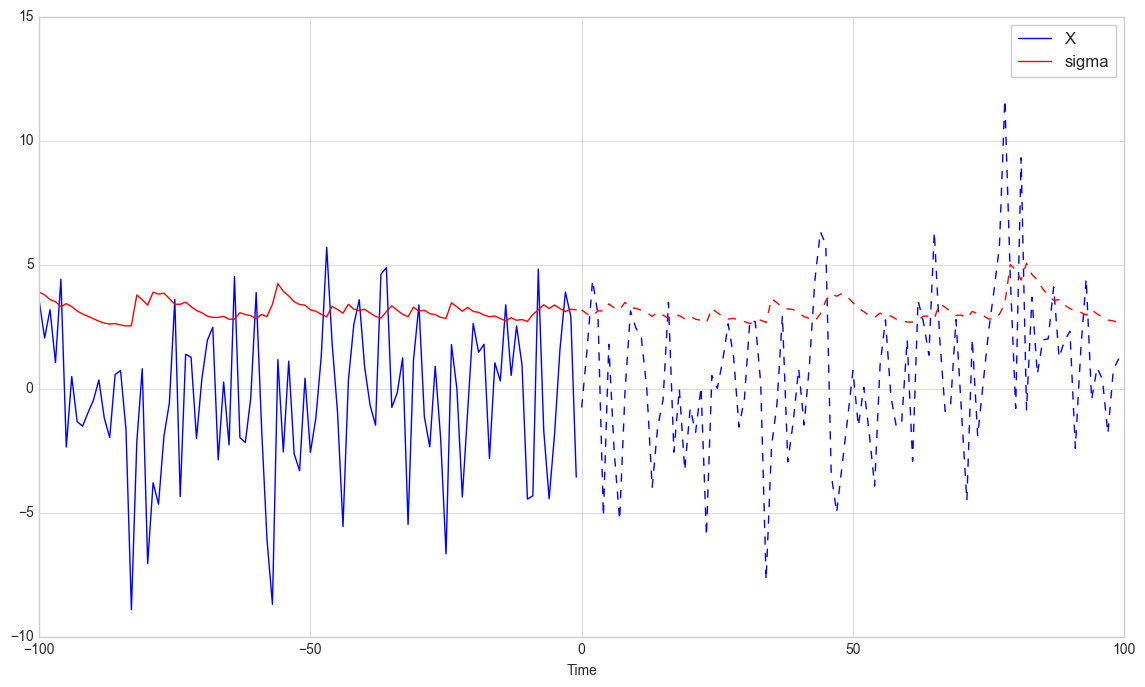

In [56]:
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.plot(range(0, 100), X_forecast, 'b--')
plt.plot(range(0, 100), sigma_forecast, 'r--')
plt.xlabel('Time')
plt.legend(['X', 'sigma']);

One should note that because we are moving foward using a random walk, this analysis is supposed to give us a sense of the magnitude of sigma and therefore the risk we could face. It is not supposed to accurately model future values of X. In practice we want to use Monte Carlo sampling to generate thousands of future scenarios, and then look at the potential range of outputs. Let's do that now. 